In [2]:
forest_extractimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.over_sampling import SMOTE 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import *
from sklearn.dummy import DummyClassifier
import itertools
from sklearn.tree import export_graphviz
from sklearn.model_selection import *
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import *
from sklearn.svm import *
from sklearn.decomposition import PCA
import re
import pprint

% matplotlib inline
%timeit

/home/zhouza/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/zhouza/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from model_selection_functions import *

In [4]:
df_train = pd.read_pickle('pickles/df_train.pkl')
df_test = pd.read_pickle('pickles/df_test.pkl')

In [5]:
X_train = df_train[df_train.columns[:-1]]
y_train = df_train['virus_present']
X_test = df_test[df_test.columns[:-1]]
y_test = df_test['virus_present']

In [6]:
X_col_log = ['date', 'month', 'latitude',
       'longitude', 'msqto_log', 'tmax', 'tmin', 'tavg', 'delta', 'dewpt',
       'wetbulb', 'heat_log', 'cool', 'sunrise', 'sunset_log', 
        'precip_log', 'pressure', 'sealvlpressure', 'windspeed',
       'winddirection', 'avgspeed', 
       'spray_targeted_prev', 'spray_targeted', 'species_culex_pipiens',
       'species_culex_pipiens_restuans', 'species_culex_restuans',
       'species_culex_salinarius', 'species_culex_tarsalis',
       'species_culex_territans']

pickle.dump(X_col_log, open('pickles/X_col_log.pkl', 'wb'))

In [6]:
ssX = StandardScaler()
ssX.fit(X_train[X_col_log[1:]])

X_train_s = ssX.transform(X_train[X_col_log[1:]])
Xy_train_s = np.concatenate((X_train_s, y_train.values.reshape(-1,1)), axis=1)
df_train_s = pd.DataFrame(Xy_train_s, columns=list(X_col_log[1:]) + ['virus_present'])

X_test_s = ssX.transform(X_test[X_col_log[1:]])
Xy_test_s = np.concatenate((X_test_s, y_test.values.reshape(-1,1)), axis=1)
df_test_s = pd.DataFrame(Xy_test_s, columns=list(X_col_log[1:]) + ['virus_present'])

pickle.dump(X_train_s, open('pickles/X_train_s.pkl', 'wb'))
pickle.dump(df_train_s, open('pickles/df_train_s.pkl', 'wb'))
pickle.dump(X_test_s, open('pickles/X_test_s.pkl', 'wb'))
pickle.dump(df_test_s, open('pickles/df_test_s.pkl', 'wb'))

pickle.dump(ssX, open('pickles/ssX.pkl', 'wb'))

In [7]:
# if reloading, run this cell instead of the one above
X_train_s=pickle.load(open('pickles/X_train_s.pkl', 'rb'))
df_train_s=pickle.load(open('pickles/df_train_s.pkl', 'rb'))
X_test_s=pickle.load(open('pickles/X_test_s.pkl', 'rb'))
df_test_s=pickle.load(open('pickles/df_test_s.pkl', 'rb'))

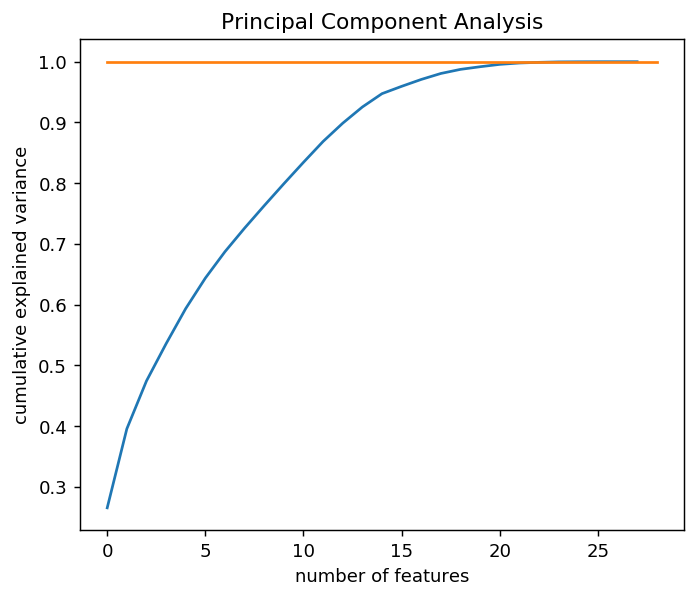

In [11]:
# PCA because there are collinear features
# from the graph, it looks like 20 features contribute to about 99% of the variance in the data

pca = PCA().fit(df_train_s[X_col_log[1:]],y_train)
plt.figure(figsize=(6,5),dpi=130)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot([0,len(X_col_log[1:])],[1,1])
plt.title('Principal Component Analysis')
plt.xlabel('number of features')
plt.ylabel('cumulative explained variance');

In [9]:
np.cumsum(pca.explained_variance_ratio_)

array([0.26551796, 0.39560765, 0.47439872, 0.53571349, 0.59358871,
       0.64375913, 0.68723779, 0.7260307 , 0.76297007, 0.79907334,
       0.83435636, 0.8687093 , 0.8987557 , 0.92541105, 0.9473681 ,
       0.95942263, 0.97077553, 0.98061285, 0.98736808, 0.99171222,
       0.99559842, 0.99786387, 0.99894233, 0.99968464, 0.99987958,
       0.99998432, 1.        , 1.        ])

To identify which ratio to use for SMOTE, run through a some base models and check for highest recall score.

In [10]:
def run_rsmpl_functions(X,y,ratio):
    X_rsmpl,y_rsmpl = gen_resample(df_train_s[df_train_s.columns[:-1]],y_train,ratio)

    pca = PCA().fit(X_rsmpl,y_rsmpl)
    pca_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(np.round(pca_var,3)>=0.995)[0][0]

    forest_model = gen_model_rsmpl(ratio,RandomForestClassifier(n_estimators=20),'randomforest')
    pcaforest_model = gen_model_rsmpl(ratio,make_pipeline(PCA(n_components=n_components),RandomForestClassifier(n_estimators=20)),'pcaforest')
    pcalog_model = gen_model_rsmpl(ratio,make_pipeline(PCA(n_components=n_components),LogisticRegression()),'pcalog')
    pcaknn_model = gen_model_rsmpl(ratio,make_pipeline(PCA(n_components=n_components),KNeighborsClassifier()),'pcaknn')
    pcasvc_model = gen_model_rsmpl(ratio,make_pipeline(PCA(n_components=n_components),SVC()),'pcasvc')
    pcagnb_model = gen_model_rsmpl(ratio,make_pipeline(PCA(n_components=n_components),GaussianNB()),'pcagnb')

    model_dict = {'randomforest':forest_model,'pcaforest':pcaforest_model,'pcalog':pcalog_model,'pcaknn':pcaknn_model,'pcasvc':pcasvc_model,'pcagnb':pcagnb_model}

    run_model_comparison(X_rsmpl,y_rsmpl,model_dict)

/home/zhouza/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


randomforest
training scores:
{'accuracy': 0.9984, 'f1': 0.9959, 'precision': 0.9987, 'recall': 0.9931}
cv scores:
{'accuracy': [0.8909, 0.9451, 0.947, 0.9457, 0.9438],
 'f1': [0.6833, 0.8685, 0.8638, 0.8686, 0.8541],
 'precision': [0.7823, 0.8656, 0.8704, 0.8541, 0.8392],
 'recall': [0.5826, 0.8536, 0.8816, 0.8781, 0.9094]}




<Figure size 2100x1120 with 0 Axes>

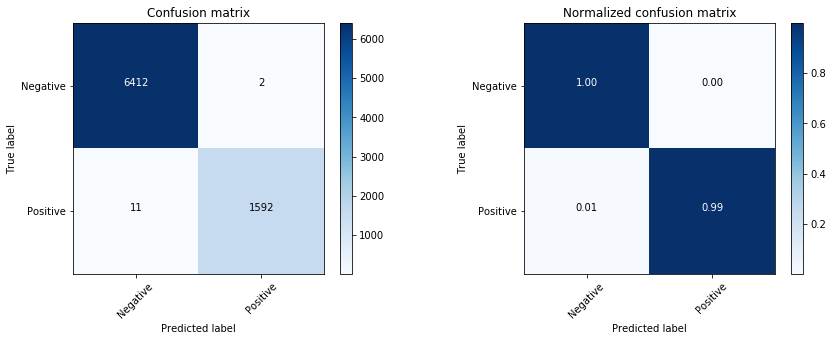

pcaforest
training scores:
{'accuracy': 0.9988, 'f1': 0.9969, 'precision': 0.9987, 'recall': 0.995}
cv scores:
{'accuracy': [0.9077, 0.9327, 0.9277, 0.9376, 0.9357],
 'f1': [0.7508, 0.7943, 0.7936, 0.8281, 0.8217],
 'precision': [0.8188, 0.8322, 0.8127, 0.837, 0.811],
 'recall': [0.7196, 0.7975, 0.7944, 0.8188, 0.8312]}




<Figure size 2100x1120 with 0 Axes>

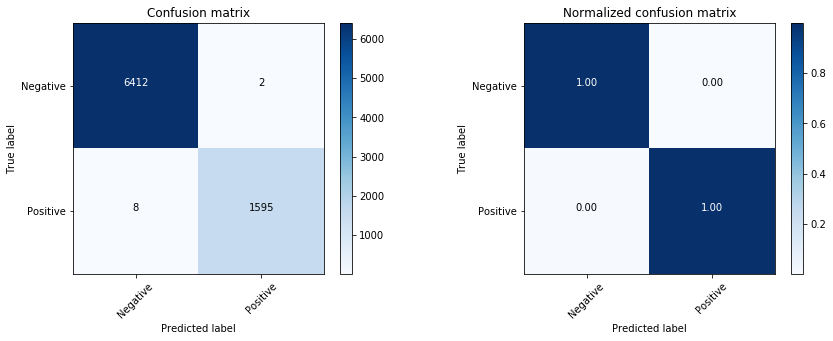

pcalog
training scores:
{'accuracy': 0.859, 'f1': 0.6103, 'precision': 0.6823, 'recall': 0.5521}
cv scores:
{'accuracy': [0.8566, 0.8535, 0.8516, 0.8621, 0.8677],
 'f1': [0.6007, 0.5913, 0.5868, 0.6196, 0.6419],
 'precision': [0.6784, 0.6693, 0.6627, 0.6897, 0.6985],
 'recall': [0.5389, 0.5296, 0.5265, 0.5625, 0.5938]}




<Figure size 2100x1120 with 0 Axes>

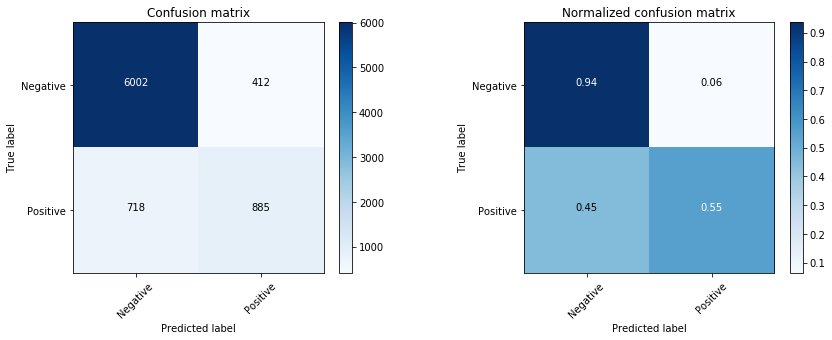

pcaknn
training scores:
{'accuracy': 0.9435, 'f1': 0.8693, 'precision': 0.8085, 'recall': 0.9401}
cv scores:
{'accuracy': [0.8959, 0.9102, 0.9065, 0.9083, 0.9132],
 'f1': [0.7526, 0.7844, 0.7899, 0.7897, 0.8034],
 'precision': [0.7175, 0.755, 0.7176, 0.7282, 0.7339],
 'recall': [0.7913, 0.8162, 0.8785, 0.8625, 0.8875]}




<Figure size 2100x1120 with 0 Axes>

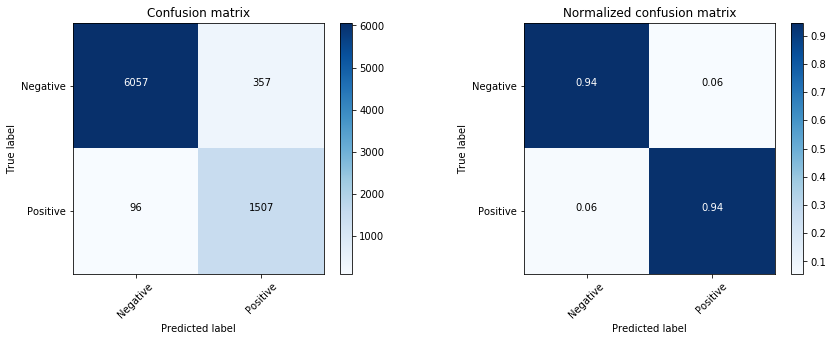

pcasvc
training scores:
{'accuracy': 0.9002, 'f1': 0.7386, 'precision': 0.7756, 'recall': 0.7049}
cv scores:
{'accuracy': [0.8759, 0.8897, 0.889, 0.8933, 0.9032],
 'f1': [0.6754, 0.7055, 0.7092, 0.7192, 0.752],
 'precision': [0.7089, 0.7571, 0.7457, 0.7578, 0.7705],
 'recall': [0.6449, 0.6604, 0.676, 0.6844, 0.7344]}




<Figure size 2100x1120 with 0 Axes>

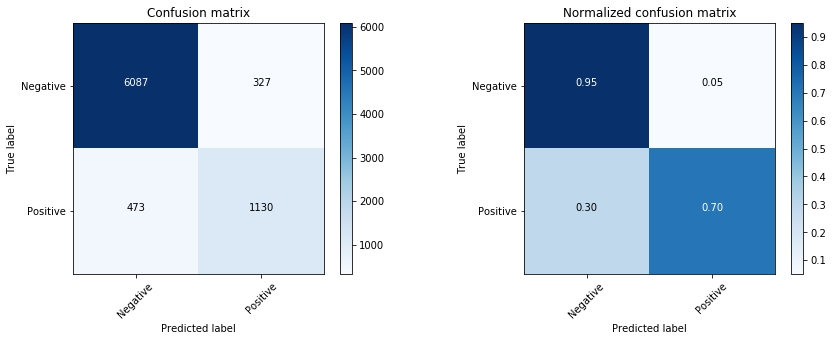

pcagnb
training scores:
{'accuracy': 0.709, 'f1': 0.5425, 'precision': 0.3956, 'recall': 0.8628}
cv scores:
{'accuracy': [0.7625, 0.7537, 0.7213, 0.7873, 0.7378],
 'f1': [0.5616, 0.5664, 0.5517, 0.603, 0.5634],
 'precision': [0.4453, 0.4373, 0.4068, 0.4805, 0.4221],
 'recall': [0.7601, 0.8037, 0.8567, 0.8094, 0.8469]}




<Figure size 2100x1120 with 0 Axes>

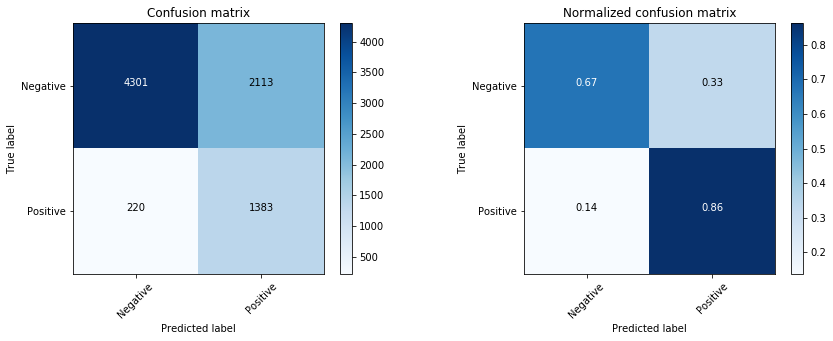

In [11]:
run_rsmpl_functions(df_train_s[df_train_s.columns[1:]],y_train,ratio=.25)

/home/zhouza/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


randomforest
training scores:
{'accuracy': 0.9988, 'f1': 0.9981, 'precision': 0.9984, 'recall': 0.9978}
cv scores:
{'accuracy': [0.9023, 0.9506, 0.9563, 0.9553, 0.9527],
 'f1': [0.8452, 0.9298, 0.9359, 0.9384, 0.9275],
 'precision': [0.881, 0.9272, 0.9075, 0.9048, 0.9015],
 'recall': [0.7975, 0.9533, 0.9672, 0.9532, 0.9594]}




<Figure size 2100x1120 with 0 Axes>

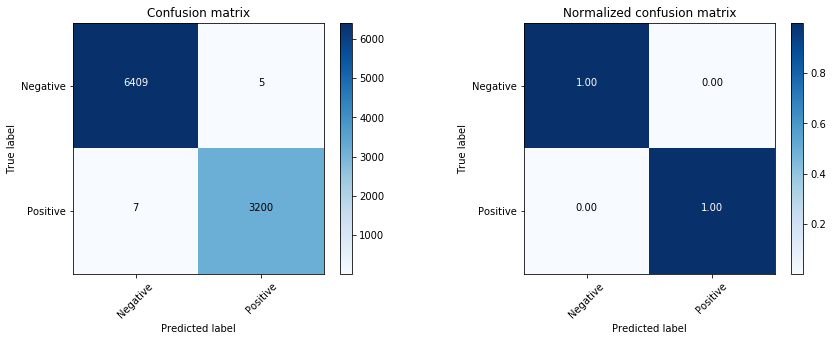

pcaforest
training scores:
{'accuracy': 0.9993, 'f1': 0.9989, 'precision': 0.9984, 'recall': 0.9994}
cv scores:
{'accuracy': [0.9184, 0.9397, 0.9371, 0.9423, 0.9236],
 'f1': [0.8683, 0.9057, 0.9067, 0.9084, 0.8846],
 'precision': [0.8782, 0.9118, 0.8989, 0.9064, 0.8877],
 'recall': [0.866, 0.9268, 0.9251, 0.9345, 0.8939]}




<Figure size 2100x1120 with 0 Axes>

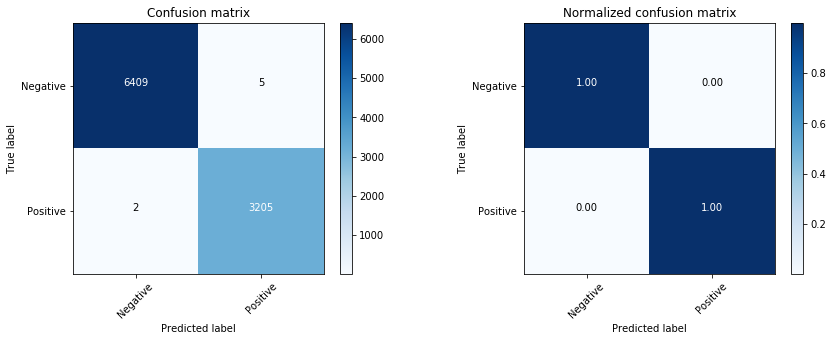

pcalog
training scores:
{'accuracy': 0.8287, 'f1': 0.7406, 'precision': 0.7477, 'recall': 0.7337}
cv scores:
{'accuracy': [0.8234, 0.8306, 0.8316, 0.8285, 0.8263],
 'f1': [0.7289, 0.7445, 0.7457, 0.7426, 0.7382],
 'precision': [0.7467, 0.7492, 0.7504, 0.7426, 0.7417],
 'recall': [0.7118, 0.7399, 0.741, 0.7426, 0.7348]}




<Figure size 2100x1120 with 0 Axes>

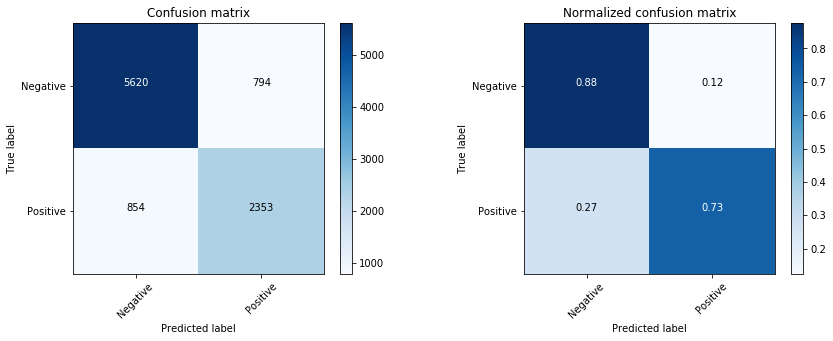

pcaknn
training scores:
{'accuracy': 0.9429, 'f1': 0.92, 'precision': 0.8637, 'recall': 0.9841}
cv scores:
{'accuracy': [0.9055, 0.9314, 0.9064, 0.9137, 0.908],
 'f1': [0.8702, 0.9046, 0.8725, 0.8821, 0.874],
 'precision': [0.8026, 0.8437, 0.799, 0.8096, 0.8037],
 'recall': [0.9502, 0.9751, 0.961, 0.9688, 0.9579]}




<Figure size 2100x1120 with 0 Axes>

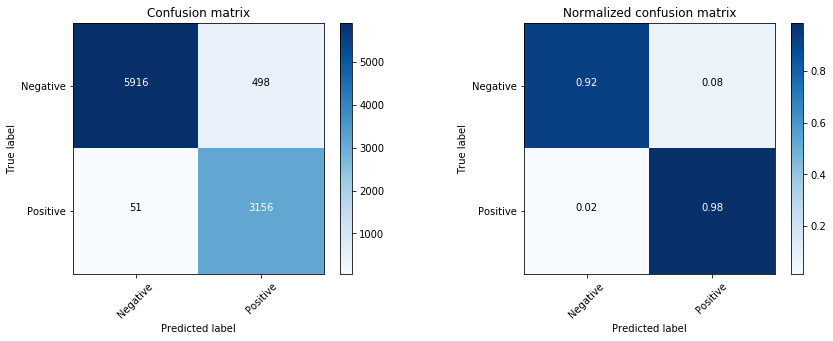

pcasvc
training scores:
{'accuracy': 0.8945, 'f1': 0.8467, 'precision': 0.8208, 'recall': 0.8743}
cv scores:
{'accuracy': [0.8597, 0.8857, 0.8857, 0.8888, 0.8794],
 'f1': [0.7939, 0.8318, 0.8356, 0.8408, 0.8237],
 'precision': [0.7784, 0.8168, 0.802, 0.8037, 0.803],
 'recall': [0.81, 0.8474, 0.8721, 0.8814, 0.8456]}




<Figure size 2100x1120 with 0 Axes>

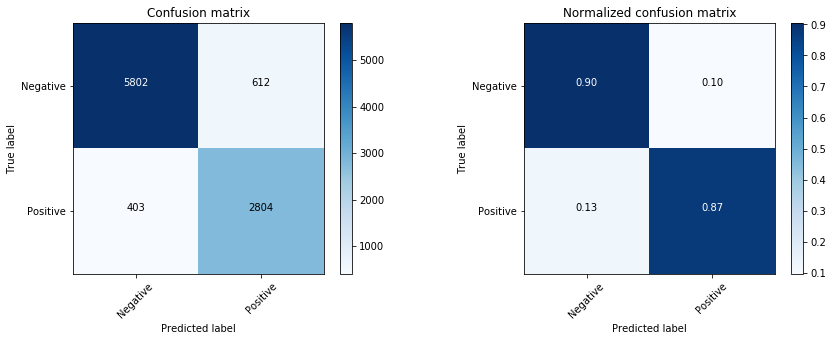

pcagnb
training scores:
{'accuracy': 0.7168, 'f1': 0.6846, 'precision': 0.5444, 'recall': 0.922}
cv scores:
{'accuracy': [0.7309, 0.7782, 0.7308, 0.7755, 0.7311],
 'f1': [0.6775, 0.7222, 0.6864, 0.7195, 0.6996],
 'precision': [0.5643, 0.6201, 0.5608, 0.6162, 0.5574],
 'recall': [0.8474, 0.8645, 0.8846, 0.8643, 0.9392]}




<Figure size 2100x1120 with 0 Axes>

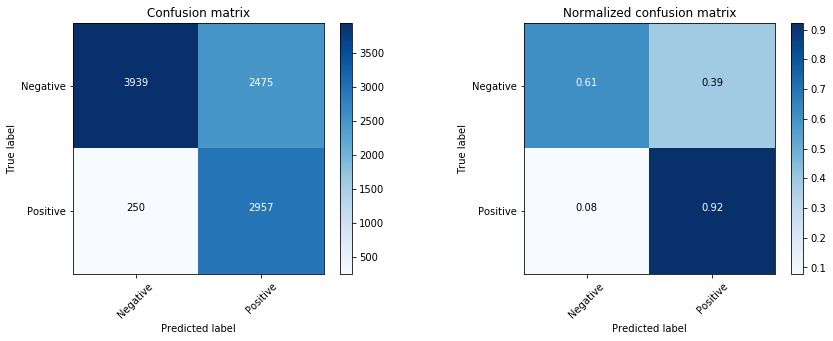

In [12]:
run_rsmpl_functions(df_train_s[df_train_s.columns[1:]],y_train,ratio=0.5)

/home/zhouza/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


randomforest
training scores:
{'accuracy': 0.9988, 'f1': 0.9985, 'precision': 0.9983, 'recall': 0.9988}
cv scores:
{'accuracy': [0.9091, 0.9644, 0.9555, 0.9572, 0.9541],
 'f1': [0.8985, 0.9603, 0.9493, 0.9568, 0.9507],
 'precision': [0.9115, 0.9373, 0.9294, 0.9284, 0.9301],
 'recall': [0.8659, 0.9823, 0.9688, 0.9782, 0.9751]}




<Figure size 2100x1120 with 0 Axes>

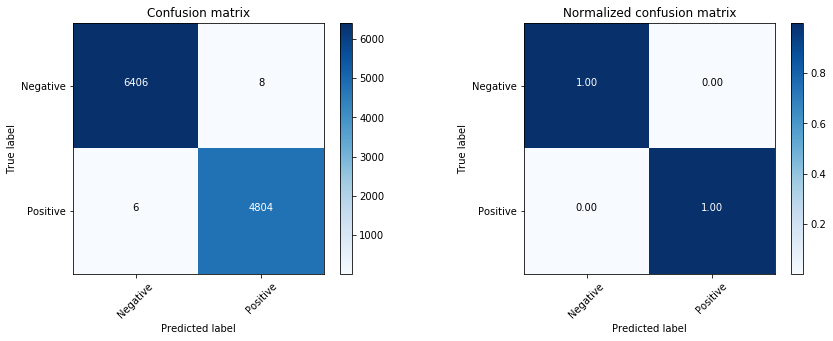

pcaforest
training scores:
{'accuracy': 0.9993, 'f1': 0.9992, 'precision': 0.9988, 'recall': 0.9996}
cv scores:
{'accuracy': [0.9269, 0.9506, 0.9359, 0.947, 0.9425],
 'f1': [0.9236, 0.9464, 0.9356, 0.9448, 0.932],
 'precision': [0.9047, 0.9296, 0.906, 0.9189, 0.9099],
 'recall': [0.9241, 0.9615, 0.9511, 0.9626, 0.9491]}




<Figure size 2100x1120 with 0 Axes>

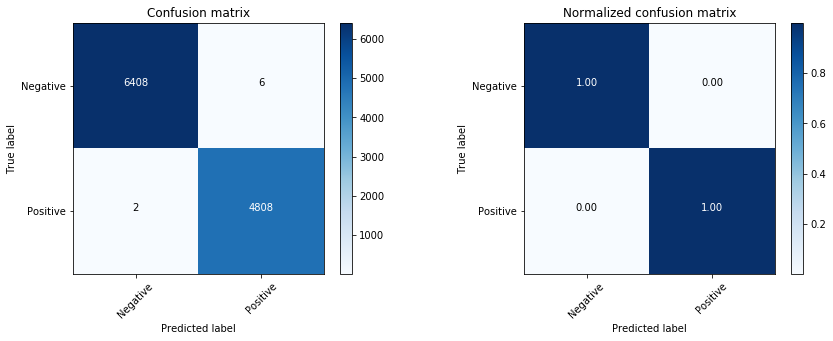

pcalog
training scores:
{'accuracy': 0.8243, 'f1': 0.7989, 'precision': 0.784, 'recall': 0.8143}
cv scores:
{'accuracy': [0.8258, 0.8178, 0.8236, 0.8192, 0.8249],
 'f1': [0.8002, 0.7895, 0.7973, 0.7941, 0.8022],
 'precision': [0.7869, 0.7819, 0.7853, 0.7752, 0.7776],
 'recall': [0.8139, 0.7973, 0.8098, 0.8139, 0.8285]}




<Figure size 2100x1120 with 0 Axes>

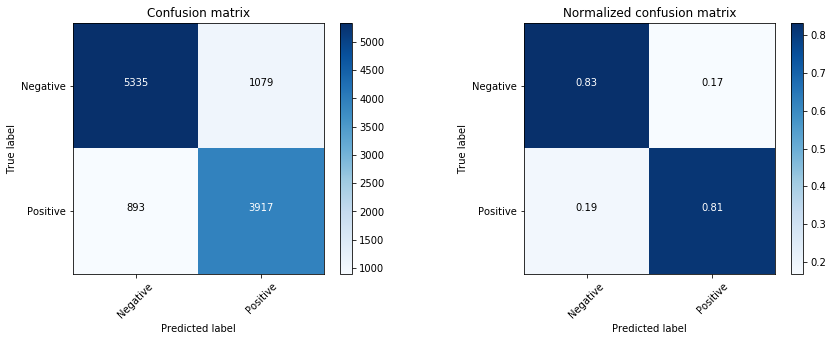

pcaknn
training scores:
{'accuracy': 0.9468, 'f1': 0.9412, 'precision': 0.8937, 'recall': 0.9942}
cv scores:
{'accuracy': [0.9131, 0.9332, 0.9149, 0.9198, 0.9176],
 'f1': [0.9062, 0.9269, 0.9089, 0.9133, 0.911],
 'precision': [0.8433, 0.8725, 0.8396, 0.851, 0.8478],
 'recall': [0.9792, 0.9886, 0.9906, 0.9854, 0.9844]}




<Figure size 2100x1120 with 0 Axes>

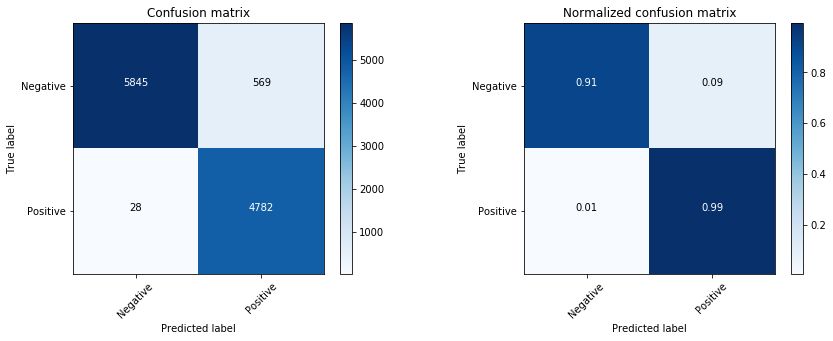

pcasvc
training scores:
{'accuracy': 0.9007, 'f1': 0.89, 'precision': 0.8471, 'recall': 0.9374}
cv scores:
{'accuracy': [0.8793, 0.9011, 0.8904, 0.8904, 0.893],
 'f1': [0.8655, 0.8906, 0.8787, 0.8791, 0.8827],
 'precision': [0.8281, 0.8464, 0.8358, 0.834, 0.833],
 'recall': [0.9064, 0.9397, 0.9262, 0.9293, 0.9387]}




<Figure size 2100x1120 with 0 Axes>

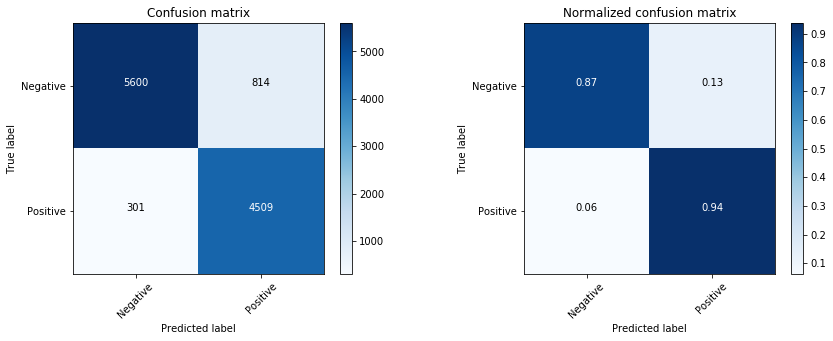

pcagnb
training scores:
{'accuracy': 0.7297, 'f1': 0.7473, 'precision': 0.6234, 'recall': 0.9324}
cv scores:
{'accuracy': [0.7243, 0.755, 0.7612, 0.7608, 0.725],
 'f1': [0.7389, 0.7611, 0.7674, 0.7578, 0.7432],
 'precision': [0.6217, 0.6537, 0.6587, 0.6693, 0.6197],
 'recall': [0.9106, 0.9106, 0.9189, 0.8732, 0.9283]}




<Figure size 2100x1120 with 0 Axes>

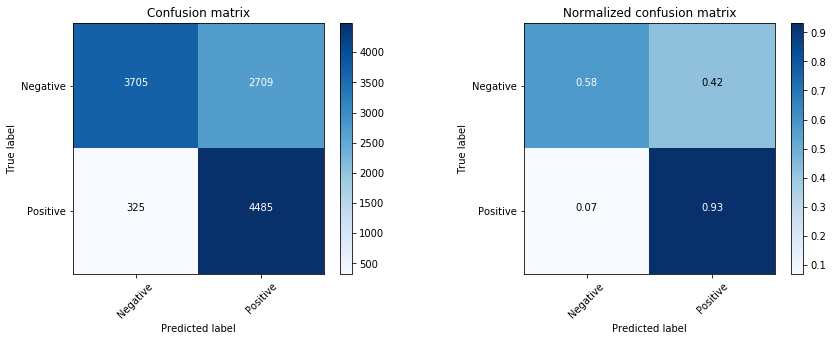

In [13]:
run_rsmpl_functions(df_train_s[df_train_s.columns[1:]],y_train,ratio=0.75)

/home/zhouza/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


randomforest
training scores:
{'accuracy': 0.9991, 'f1': 0.9991, 'precision': 0.9992, 'recall': 0.9991}
cv scores:
{'accuracy': [0.9283, 0.9638, 0.9614, 0.9638, 0.961],
 'f1': [0.9243, 0.9655, 0.9627, 0.9686, 0.959],
 'precision': [0.9358, 0.9543, 0.9409, 0.9453, 0.9357],
 'recall': [0.9189, 0.9797, 0.9852, 0.9844, 0.9875]}




<Figure size 2100x1120 with 0 Axes>

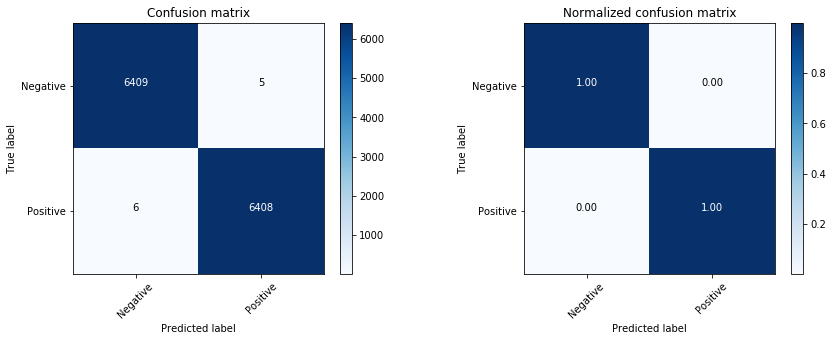

pcaforest
training scores:
{'accuracy': 0.9995, 'f1': 0.9995, 'precision': 0.9995, 'recall': 0.9995}
cv scores:
{'accuracy': [0.9431, 0.954, 0.9536, 0.9567, 0.945],
 'f1': [0.946, 0.9602, 0.9517, 0.9595, 0.9501],
 'precision': [0.9246, 0.9374, 0.9327, 0.9348, 0.9206],
 'recall': [0.9673, 0.9743, 0.979, 0.9782, 0.9696]}




<Figure size 2100x1120 with 0 Axes>

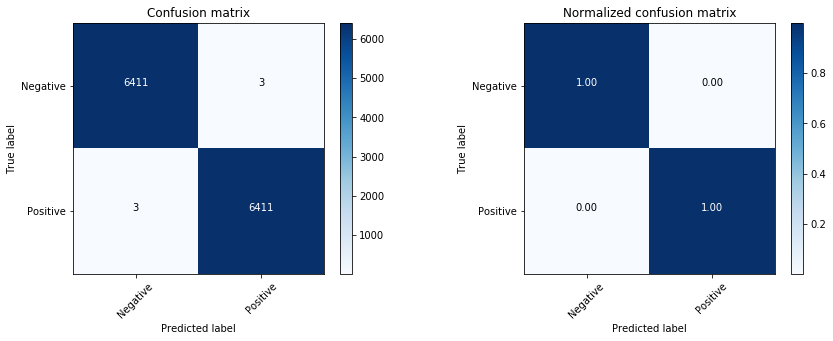

pcalog
training scores:
{'accuracy': 0.8275, 'f1': 0.8327, 'precision': 0.8081, 'recall': 0.8589}
cv scores:
{'accuracy': [0.8207, 0.8277, 0.8246, 0.8316, 0.8331],
 'f1': [0.824, 0.8321, 0.8292, 0.8377, 0.8405],
 'precision': [0.8092, 0.8117, 0.8083, 0.8086, 0.8046],
 'recall': [0.8394, 0.8535, 0.8511, 0.8691, 0.8799]}




<Figure size 2100x1120 with 0 Axes>

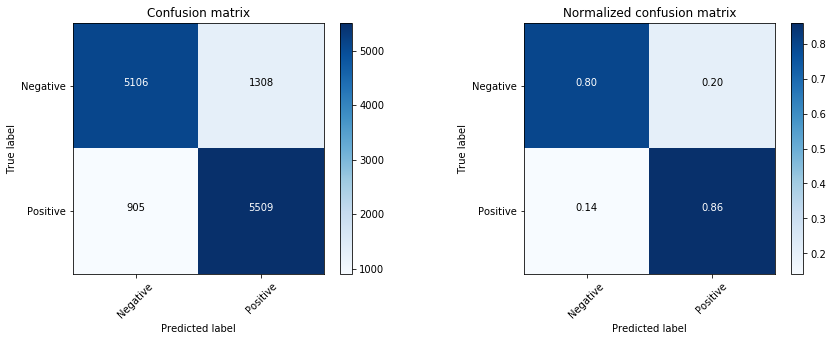

pcaknn
training scores:
{'accuracy': 0.9503, 'f1': 0.9525, 'precision': 0.9113, 'recall': 0.9977}
cv scores:
{'accuracy': [0.9174, 0.9408, 0.9228, 0.9275, 0.9278],
 'f1': [0.9226, 0.9438, 0.9278, 0.9317, 0.9323],
 'precision': [0.868, 0.8974, 0.8713, 0.8812, 0.878],
 'recall': [0.9844, 0.9953, 0.9922, 0.9883, 0.9938]}




<Figure size 2100x1120 with 0 Axes>

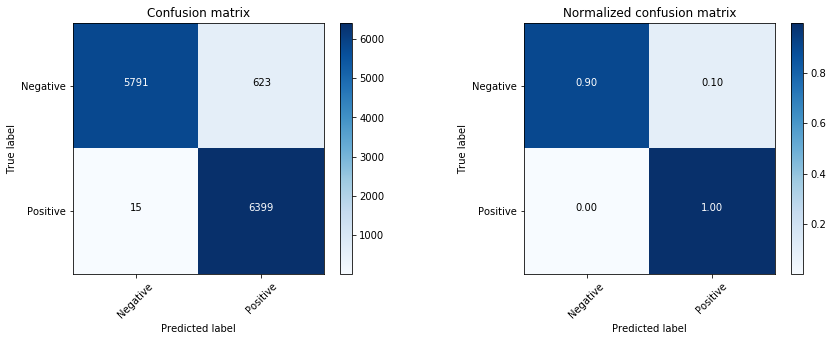

pcasvc
training scores:
{'accuracy': 0.9095, 'f1': 0.9145, 'precision': 0.8668, 'recall': 0.9677}
cv scores:
{'accuracy': [0.8843, 0.9053, 0.8963, 0.9006, 0.8982],
 'f1': [0.8898, 0.9099, 0.9018, 0.9071, 0.9041],
 'precision': [0.8492, 0.8678, 0.8568, 0.8516, 0.8543],
 'recall': [0.9345, 0.9564, 0.9517, 0.9704, 0.9602]}




<Figure size 2100x1120 with 0 Axes>

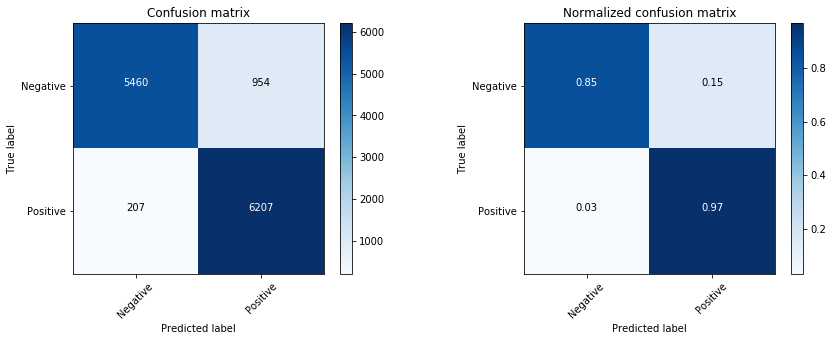

pcagnb
training scores:
{'accuracy': 0.7565, 'f1': 0.7864, 'precision': 0.7005, 'recall': 0.8962}
cv scores:
{'accuracy': [0.7319, 0.7607, 0.7779, 0.7724, 0.7559],
 'f1': [0.776, 0.7903, 0.7999, 0.8014, 0.7891],
 'precision': [0.6663, 0.7033, 0.7278, 0.7109, 0.6945],
 'recall': [0.9291, 0.9018, 0.8878, 0.9182, 0.9134]}




<Figure size 2100x1120 with 0 Axes>

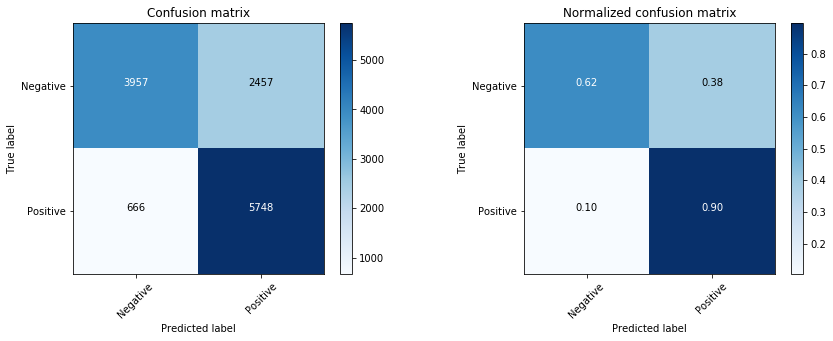

In [14]:
run_rsmpl_functions(df_train_s[df_train_s.columns[1:]],y_train,ratio=1.0)

Compare SMOTE resampling with using class_weight = 'balanced' on original train set:

randomforest
training scores:
{'accuracy': 0.9968, 'f1': 0.969, 'precision': 1.0, 'recall': 0.9399}
cv scores:
{'accuracy': [0.9469, 0.944, 0.9447, 0.9403, 0.9402],
 'f1': [0.198, 0.1935, 0.24, 0.26, 0.3119],
 'precision': [0.3846, 0.44, 0.4286, 0.3929, 0.4583],
 'recall': [0.1622, 0.137, 0.1507, 0.137, 0.1918]}




<Figure size 2100x1120 with 0 Axes>

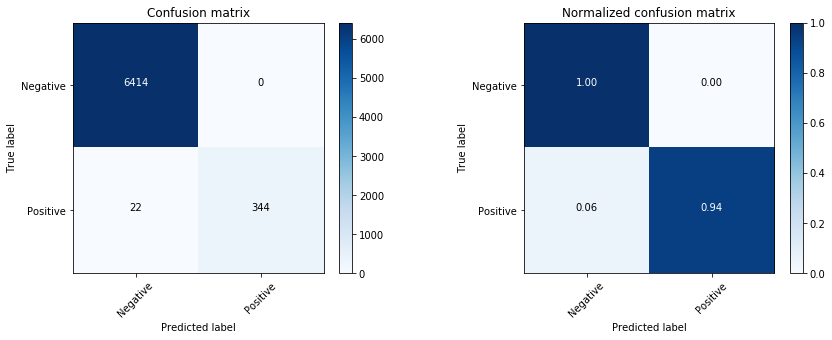

pcaforest
training scores:
{'accuracy': 0.9959, 'f1': 0.9602, 'precision': 1.0, 'recall': 0.9235}
cv scores:
{'accuracy': [0.9455, 0.9447, 0.9469, 0.9432, 0.938],
 'f1': [0.2041, 0.1304, 0.2041, 0.2526, 0.1474],
 'precision': [0.4815, 0.3529, 0.4583, 0.32, 0.3793],
 'recall': [0.1622, 0.0822, 0.137, 0.1781, 0.1507]}




<Figure size 2100x1120 with 0 Axes>

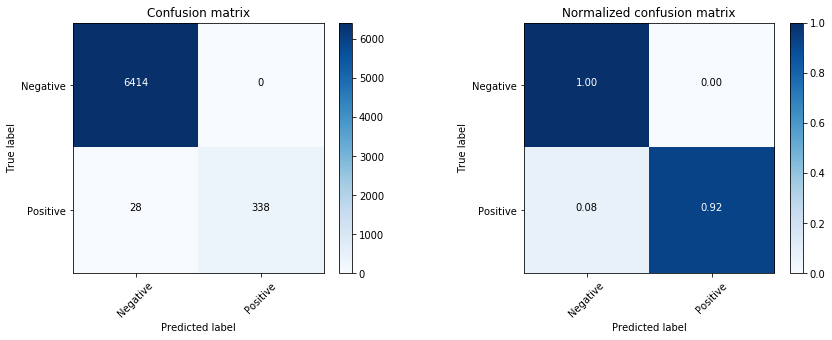

pcalog
training scores:
{'accuracy': 0.7897, 'f1': 0.303, 'precision': 0.1845, 'recall': 0.847}
cv scores:
{'accuracy': [0.787, 0.8031, 0.7898, 0.7817, 0.7815],
 'f1': [0.32, 0.2992, 0.3066, 0.278, 0.2952],
 'precision': [0.1937, 0.1851, 0.1864, 0.1691, 0.1787],
 'recall': [0.9189, 0.7808, 0.863, 0.7808, 0.8493]}




<Figure size 2100x1120 with 0 Axes>

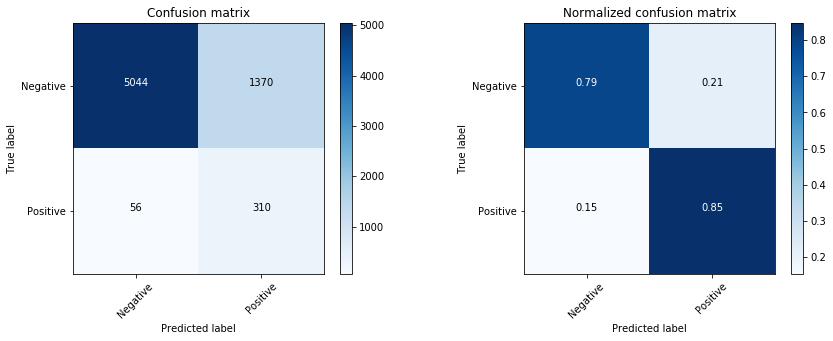

pcaknn
training scores:
{'accuracy': 0.956, 'f1': 0.4377, 'precision': 0.7073, 'recall': 0.3169}
cv scores:
{'accuracy': [0.9403, 0.9403, 0.9351, 0.9417, 0.9402],
 'f1': [0.2136, 0.1474, 0.2, 0.2178, 0.2136],
 'precision': [0.3793, 0.3182, 0.2973, 0.3929, 0.3667],
 'recall': [0.1486, 0.0959, 0.1507, 0.1507, 0.1507]}




<Figure size 2100x1120 with 0 Axes>

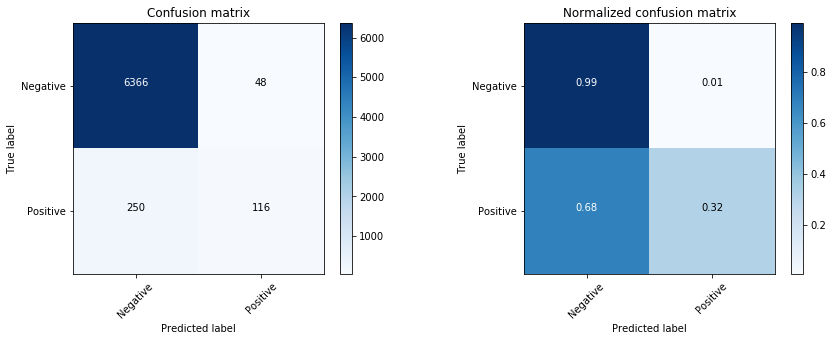

pcasvc
training scores:
{'accuracy': 0.814, 'f1': 0.351, 'precision': 0.2162, 'recall': 0.9317}
cv scores:
{'accuracy': [0.7937, 0.823, 0.8038, 0.7883, 0.803],
 'f1': [0.2929, 0.3143, 0.3214, 0.2771, 0.3065],
 'precision': [0.1801, 0.1986, 0.1975, 0.1698, 0.1891],
 'recall': [0.7838, 0.7534, 0.863, 0.7534, 0.8082]}




<Figure size 2100x1120 with 0 Axes>

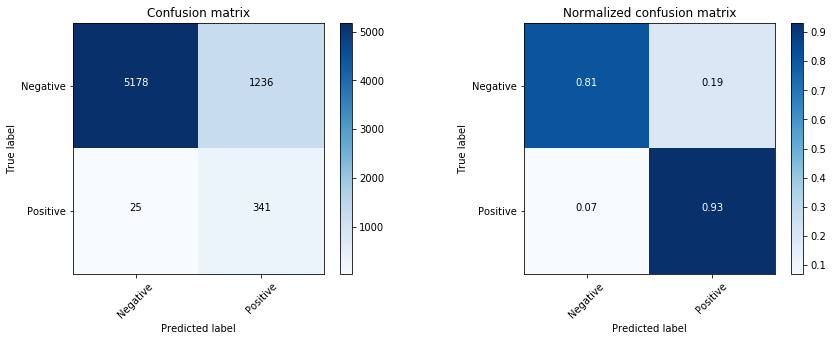

pcagnb
training scores:
{'accuracy': 0.9258, 'f1': 0.2504, 'precision': 0.2754, 'recall': 0.2295}
cv scores:
{'accuracy': [0.899, 0.9336, 0.9174, 0.924, 0.9188],
 'f1': [0.3568, 0.3382, 0.2821, 0.3522, 0.3293],
 'precision': [0.2734, 0.3651, 0.2651, 0.3256, 0.2967],
 'recall': [0.5135, 0.3151, 0.3014, 0.3836, 0.3699]}




<Figure size 2100x1120 with 0 Axes>

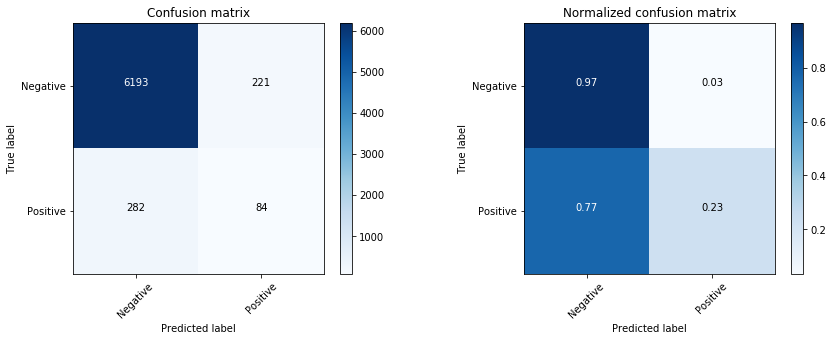

In [16]:
pca = PCA().fit(X_train_s,y_train)
pca_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(np.round(pca_var,3)>=0.995)[0][0]

forest_model = RandomForestClassifier(n_estimators=20,class_weight='balanced')
forest_model.fit(X_train_s,y_train)
pcaforest_model = make_pipeline(PCA(n_components=n_components),RandomForestClassifier(n_estimators=20,class_weight='balanced'))
pcaforest_model.fit(X_train_s,y_train)
pcalog_model = make_pipeline(PCA(n_components=n_components),LogisticRegression(class_weight='balanced'))
pcalog_model.fit(X_train_s,y_train)
pcaknn_model = make_pipeline(PCA(n_components=n_components),KNeighborsClassifier())
pcaknn_model.fit(X_train_s,y_train)
pcasvc_model = make_pipeline(PCA(n_components=n_components),SVC(class_weight='balanced'))
pcasvc_model.fit(X_train_s,y_train)
pcagnb_model = make_pipeline(PCA(n_components=n_components),GaussianNB())
pcagnb_model.fit(X_train_s,y_train)

model_dict = {'randomforest':forest_model,'pcaforest':pcaforest_model,'pcalog':pcalog_model,'pcaknn':pcaknn_model,'pcasvc':pcasvc_model,'pcagnb':pcagnb_model}

run_model_comparison(X_train_s,y_train,model_dict)

The best scores (overall and specifically recall) occur with ratio = 1.0 and models Random Forest and KNN. However, since SMOTE uses KNN to oversample, it would probably be redundant to use a KNN model for predicting. The next step would be to tune hyperparameters.

In [24]:
pickle.dump(pca,open('pickles/pca_10.pkl','wb'))

In [19]:
forest_model = pickle.load(open('pickles/randomforest_10.pkl', 'rb'))
X_rsmpl_train = pickle.load(open('pickles/X_rsmpl_train_10.pkl', 'rb'))
y_rsmpl_train = pickle.load(open('pickles/y_rsmpl_train_10.pkl', 'rb'))

forest_scores = np.array([est.score(df_train_s[X_col_log[1:]], y_train) for est in forest_model.estimators_])
forest_best = np.argmax(forest_scores)
print(str(forest_best) + ", " + str(forest_scores[forest_best]))

np.std(forest_scores)

1, 0.9690265486725663


0.002283565021527202

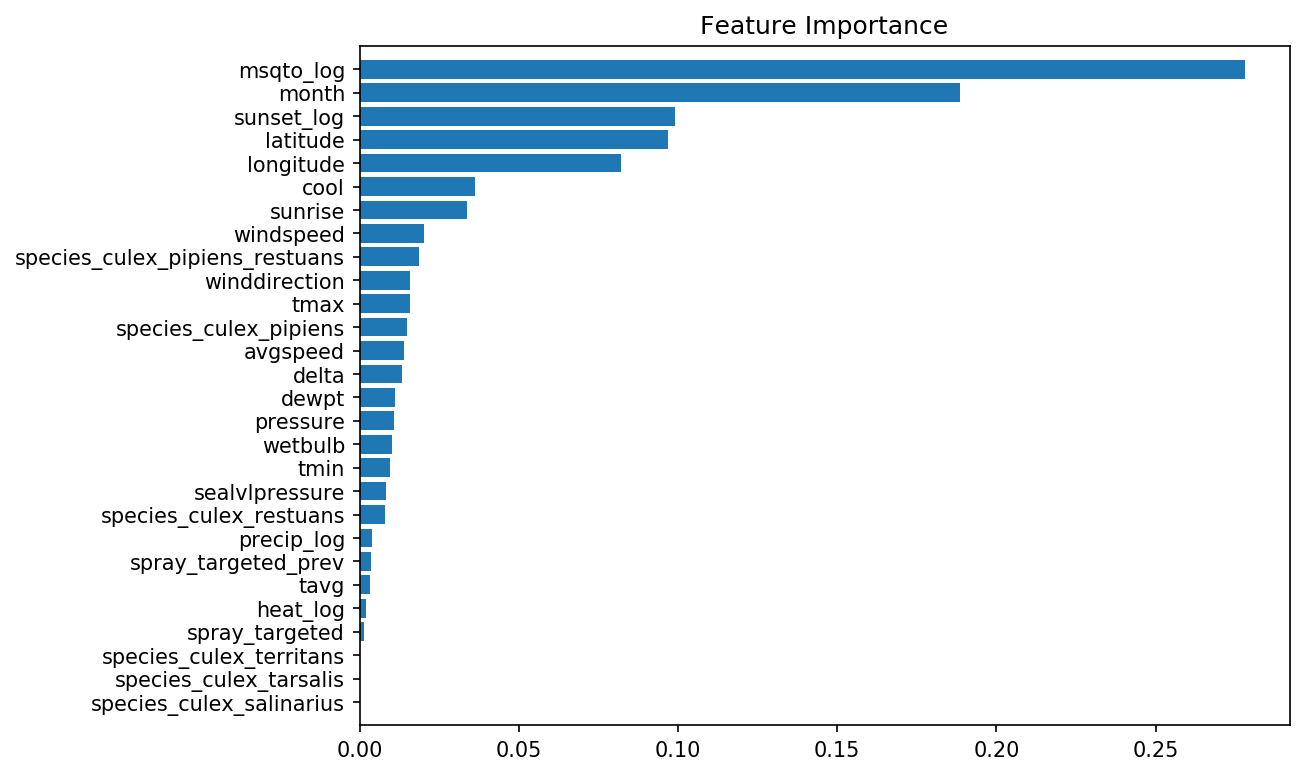

In [20]:
forest_importances = forest_model.estimators_[forest_best].feature_importances_
indices = np.argsort(forest_importances)

# Plot the feature importances of the best tree in the forest
plt.figure(figsize=(8,6),dpi=150)
plt.title("Feature Importance")
plt.barh(range(len(X_col_log[1:])), forest_importances[indices])
plt.yticks(range(len(X_col_log[1:])), [X_col_log[1+i]for i in indices])
plt.ylim([-1, len(X_col_log[1:])]);

In [21]:
# pull out best tree:
export_graphviz(forest_model.estimators_[forest_best],out_file='images/forest_best_tree.dot', max_depth=4, feature_names=X_col_log[1:])

In [22]:
!dot -Tpng images/forest_best_tree.dot -o images/forest_best_tree.png

![images/forest_best_tree](./images/forest_best_tree.png)

In [27]:
df_train[X_col_log[1:]].columns

Index(['month', 'latitude', 'longitude', 'msqto_log', 'tmax', 'tmin', 'tavg',
       'delta', 'dewpt', 'wetbulb', 'heat_log', 'cool', 'sunrise',
       'sunset_log', 'precip_log', 'pressure', 'sealvlpressure', 'windspeed',
       'winddirection', 'avgspeed', 'spray_targeted_prev', 'spray_targeted',
       'species_culex_pipiens', 'species_culex_pipiens_restuans',
       'species_culex_restuans', 'species_culex_salinarius',
       'species_culex_tarsalis', 'species_culex_territans'],
      dtype='object')